## import and introduction

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as linear_model

# Preprocessing

## Read train and test data files

In [2]:
import sklearn.preprocessing as preprocessing 

main_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")

In [3]:
print(main_df.head())

   ID      x-inv    y-inv       force
0   0 -24.234234 -50.0000  117.616636
1   1  21.771772 -49.8999  132.928749
2   2  12.702703 -49.7998  114.418568
3   3  22.792793 -49.6997  130.401770
4   4  -0.150150 -49.5996  123.536669


In [4]:
main_df_copy =main_df.copy()
main_df.drop(axis="columns", labels="ID", inplace=True)

## Check for duplicated rows

In [5]:
print(main_df.duplicated().sum())
main_df = main_df_copy.copy()
print(main_df.head())

0
   ID      x-inv    y-inv       force
0   0 -24.234234 -50.0000  117.616636
1   1  21.771772 -49.8999  132.928749
2   2  12.702703 -49.7998  114.418568
3   3  22.792793 -49.6997  130.401770
4   4  -0.150150 -49.5996  123.536669


## Check for missing values

In [6]:
print(main_df.isna().sum(),"\n")
print((main_df == "?").sum())

ID       0
x-inv    0
y-inv    0
force    0
dtype: int64 

ID       0
x-inv    0
y-inv    0
force    0
dtype: int64


## Checking for datatypes of each column

In [7]:
print(main_df.dtypes)

ID         int64
x-inv    float64
y-inv    float64
force    float64
dtype: object


## Check for skewed data

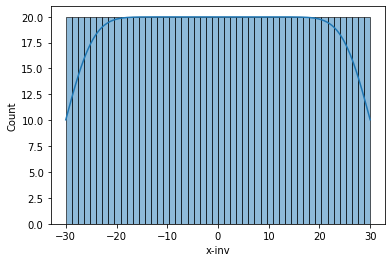

In [8]:
sns.histplot(main_df['x-inv'], bins = 50, kde=True, line_kws={"color":"red"})
plt.show()

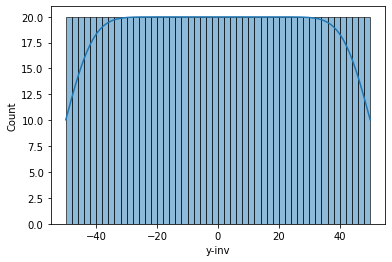

In [9]:
sns.histplot(main_df['y-inv'], bins = 50, kde=True, line_kws={"color":"red"})
plt.show()

None of the features are skewed

## Check for outliers

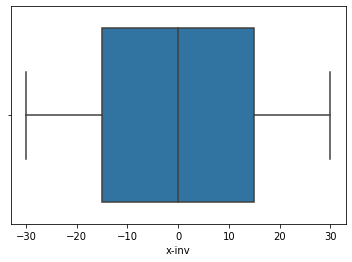

In [10]:
sns.boxplot(x=main_df['x-inv'])
plt.show()

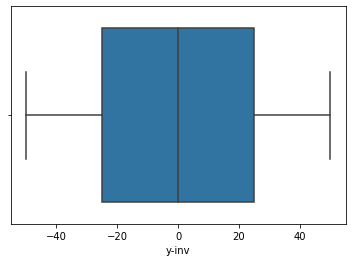

In [11]:
sns.boxplot(x=main_df['y-inv'])
plt.show()

## Check for correlation

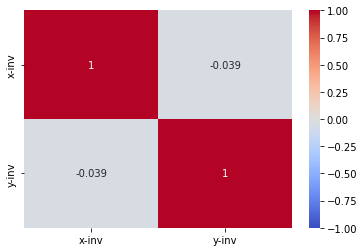

In [12]:
main_df_continuous = main_df.drop(columns=['ID','force'])
main_df_continuous.corr()
sns.heatmap(main_df_continuous.corr(), vmin=-1, cmap="coolwarm", annot=True)
plt.show()

Logically, we'd expect relative x-distance and relative y-distance to be independent and so should be their inverses (x-inv and y-inv). 

The above correlation hotmap also emphasizes that x-inv and y-inv con be considered independent columns

## Categorical features

There are no categorical features present. "ID" is used only for identification and won't be used as a feature.

## Feature normalization

In [13]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

main_df[['x-inv','y-inv']] = scaler.fit_transform(main_df[['x-inv','y-inv']]) 
print(main_df.head())

   ID     x-inv     y-inv       force
0   0 -1.397766 -1.730320  117.616636
1   1  1.255737 -1.726856  132.928749
2   2  0.732658 -1.723391  114.418568
3   3  1.314627 -1.719927  130.401770
4   4 -0.008660 -1.716463  123.536669


## Scatterplot of 'force' vs x-inv

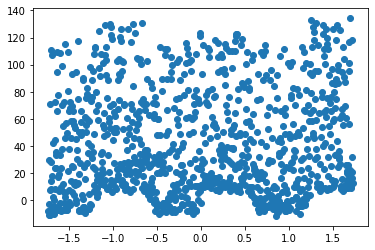

In [14]:
plt.scatter(main_df['x-inv'],main_df['force'])
plt.show()

## scatterplot of 'force' vs 'y-inv'

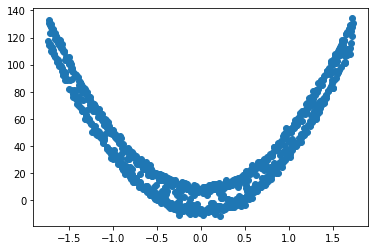

In [15]:
plt.scatter(main_df['y-inv'],main_df['force'])
plt.show()

We can conclude from the above scatter plots that a simple linear model won't do. We will have to use polynomial regression to handle these features. 

Moreover, we can see that y-inv would nicely fit a 2 degree model whereas x-inv will be needing more meticulous dealing.

Now that we're done with all the preprocessing, we can move on to model generation.

# Model generation

## train_test_split_data

## Polynomial regression

In [16]:
from sklearn.model_selection import train_test_split 

X = main_df.drop(axis="columns",labels=['ID','force']).to_numpy().astype(np.float64)
Y = main_df['force'].to_numpy().astype(np.float64)

train_X, test_X, train_y, test_y = train_test_split(X, Y, train_size=0.6)

if train_X.ndim==1:
  train_X = train_X.reshape(-1,1)
  test_X = test_X.reshape(-1,1)

## Check for for various polynomial degrees

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

i = 2
count = 0

temp_train_error = temp_test_error = 10000000
train_error = test_error = 1000000
poly_degree = reg_lambda = 2

while count < 1500:
  POLY_DEGREE = i
  feature_generator = preprocessing.PolynomialFeatures(degree=POLY_DEGREE)
  train_X_final = feature_generator.fit_transform(train_X)
  test_X_final = feature_generator.fit_transform(test_X)
  
  REG_LAMBDA = 0
  
  # print(i)
  
  while REG_LAMBDA < 0.02:
    # model = linear_model.Lasso(alpha=REG_LAMBDA, max_iter=20000)

    model = linear_model.Ridge(alpha=REG_LAMBDA)

    model.fit(train_X_final, train_y)
    
    train_yhat = model.predict(train_X_final)
    test_yhat = model.predict(test_X_final)

    temp_train_error = mean_squared_error(train_y, train_yhat)
    temp_test_error = mean_squared_error(test_y, test_yhat)

    if temp_test_error < test_error:
      if temp_train_error<=train_error or train_error-temp_train_error < 5:
        test_error = temp_test_error
        train_error = temp_train_error
        poly_degree = POLY_DEGREE
        reg_lambda = REG_LAMBDA
        # print(test_yhat)

    count+=1
    REG_LAMBDA+=0.0001

  i+=1

print("\n","Train error = ", train_error)
print("Test error = ", test_error)
print("lambda = ", reg_lambda)
print("degree = ", poly_degree)



 Train error =  8.248561851141504
Test error =  11.197728925633013
lambda =  0.003399999999999998
degree =  9


## Feature normalization for test.csv

In [18]:
print(test_df.head())
test_df[['x-inv','y-inv']] = scaler.fit_transform(test_df[['x-inv','y-inv']])
print(test_df.head())

   ID      x-inv      y-inv
0   0  -8.889889 -50.000000
1   1 -28.355836 -49.989999
2   2  15.682568 -49.979998
3   3 -19.858986 -49.969997
4   4 -22.445245 -49.959996
   ID     x-inv     y-inv
0   0 -0.513207 -1.731878
1   1 -1.636961 -1.731531
2   2  0.905343 -1.731185
3   3 -1.146444 -1.730838
4   4 -1.295747 -1.730492


In [19]:
test_X = test_df.drop(axis="columns",labels=['ID']).to_numpy().astype(np.float64)

feature_generator = preprocessing.PolynomialFeatures(degree=poly_degree)
X_final = feature_generator.fit_transform(X)
test_X_final = feature_generator.fit_transform(test_X)

model = linear_model.Ridge(alpha=reg_lambda)
model.fit(X_final, Y)

test_yhat = model.predict(test_X_final)

In [20]:
y_pred_df = pd.DataFrame(data=test_yhat, columns = ["force"])
print(y_pred_df)

submission_df = pd.concat([test_df["ID"], y_pred_df["force"]], axis=1, join='inner')
submission_df.to_csv("submission.csv", index = False)

           force
0     122.049376
1     121.815957
2     113.269280
3     127.933454
4     118.885884
...          ...
9995  129.104611
9996  114.570063
9997  126.845668
9998  129.879195
9999  114.212293

[10000 rows x 1 columns]
